### Imports

In [1]:
import jax.numpy as jnp
from jax import random
import optax
from jaxflows.bijections.coupling import CouplingStack
from jaxflows.bijections.rational_quadratic_spline import RationalQuadraticSpline
from jaxflows.flow import Flow

import equinox as eqx
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from tqdm import tqdm

### Generate data

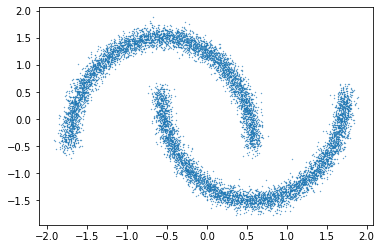

In [2]:
n_samples = 10000
n_bins = 100

scaler = preprocessing.StandardScaler()
x, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
x = scaler.fit_transform(x)
x = jnp.array(x)
plt.scatter(x[:, 0], x[:, 1], s=0.1)

### Define loss and training loop

In [3]:
@eqx.filter_value_and_grad
def loss_value_and_grad(flow, x):
    return -flow.log_prob(x).mean()

@eqx.filter_jit
def step(flow, x_batch, optimizer, opt_state):
    loss, grads = loss_value_and_grad(flow, x_batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    flow = eqx.apply_updates(flow, updates)
    return flow, opt_state, loss

    
def train(key, flow, x, optimizer, epochs, batch_size=256):
    params, _ = eqx.partition(flow, eqx.is_array)
    opt_state = optim.init(params)
    losses = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        key, subkey = random.split(key)
        x = random.permutation(key, x)
        for i in range(0, x.shape[0]-batch_size, batch_size):
            xi = x[i : i+batch_size]
            flow, opt_state, loss = step(flow, xi, optimizer, opt_state)
            losses.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})
    return flow, losses


### Train and plot samples

In [12]:
# %%time
key = random.PRNGKey(1)
bijection = CouplingStack(
    key=key,
    bijection=RationalQuadraticSpline(K=8, B=4),
    D=2,
    num_layers=8)

flow = Flow(bijection, target_dim = x.shape[1])

optim = optax.adam(5e-4)
key, subkey = random.split(key)
flow, losses = train(
    key, flow, x, optim, epochs = 30)


100%|██████████| 30/30 [00:39<00:00,  1.31s/it, loss=1.35]


(-2.3, 2.3)

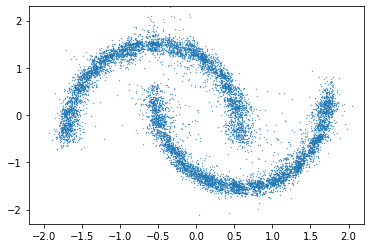

In [13]:
key, subkey = random.split(key)
x_samples = flow.sample(key, 10000)
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
plt.xlim(-2.2, 2.2)
plt.ylim(-2.3, 2.3)

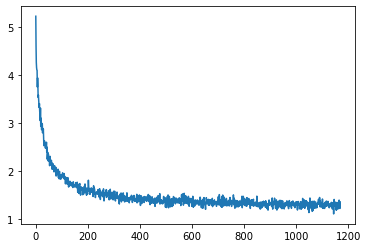

In [14]:
plt.plot(losses)